## Imports

In [1]:
from constants import FLUXES_FOLDER, SLM_FOLDER

from data_utils import load_numpy_data, \
                       flatten_data, \
                       shuffle_arrays, \
                       fuse_amplitude_and_phase, \
                       split_data, \
                       normalize_data

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_fully_connected_amp_phase_prediction

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_linear_model_for_amplitude_reconstruction, \
                           train_linear_model_for_amplitude_reconstruction

from configurations import FirstWorkingModel

2023-11-28 10:03:59.553702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 10:04:00.187357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load data

In the first place, define the data paths

In [2]:
fluxes_filename = "all_fluxes.npy"
amplitudes_filename = "complexsine_pupamp.npy"
phases_filename = "complexsine_pupphase.npy"

fluxes_path = f"{FLUXES_FOLDER}/{fluxes_filename}"
amplitudes_path = f"{SLM_FOLDER}/{amplitudes_filename}"
phases_path = f"{SLM_FOLDER}/{phases_filename}"

Read the numpy raw files

In [3]:
n_points = 10000
fluxes_array = load_numpy_data(fluxes_path,
                               n_points)

amplitudes_array = load_numpy_data(amplitudes_path,
                                   n_points)

phases_array = load_numpy_data(phases_path,
                               n_points)

Normalize data

In [4]:
fluxes_array, fluxes_scaler = normalize_data(fluxes_array)
amplitudes_array, amplitudes_scaler = normalize_data(amplitudes_array)
phases_array, phases_scaler = normalize_data(phases_array)

Shuffle the data

In [5]:
fluxes_array, amplitudes_array, phases_array = shuffle_arrays([fluxes_array,
                                                               amplitudes_array,
                                                               phases_array])

Merge phase and amplitude

In [6]:
amp_phase_array = fuse_amplitude_and_phase(amplitudes_array,
                                           phases_array)

Flatten input fluxes

In [7]:
flattened_fluxes_array = flatten_data(fluxes_array)
flattened_fluxes_array.shape

(10000, 1320)

Split data in train and validation set

In [8]:
val_ratio = 0.1
train_flattened_fluxes_array, val_flattened_fluxes_array = split_data(flattened_fluxes_array,
                                                                      val_ratio)

train_amp_phase_array, val_amp_phase_array = split_data(amp_phase_array,
                                                        val_ratio)

In [9]:
amp_phase_array.shape

(10000, 2, 96, 96)

In [10]:
train_amp_phase_array.shape

(9000, 2, 96, 96)

In [11]:
train_flattened_fluxes_array.shape

(9000, 1320)

## Define the model

In [12]:
model_configuration = FirstWorkingModel(train_flattened_fluxes_array,
                          train_amp_phase_array)
print(model_configuration.get_description())


	=== AmplitudePhaseReconstructor1 ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: (1320,)
		-Output shape: (2, 96, 96)
		-Hidden layers: [1024, 2048, 2048, 2048]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 1000
		-Batch size: 128
		-Callbacks:
			-Early Stop: MSE 50
			-ReduceLROnPlateau: MSE 15 x0.1
	


2023-11-28 10:04:06.979065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 10:04:07.009206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 10:04:07.009488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


## Compile model

In [14]:
compile_linear_model_for_amplitude_reconstruction(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

## Train model

In [15]:
history = train_linear_model_for_amplitude_reconstruction(
    model,
    train_flattened_fluxes_array,
    train_amp_phase_array,
    val_flattened_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

2023-11-28 10:04:08.199227: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 663552000 exceeds 10% of free system memory.
2023-11-28 10:04:08.740836: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 663552000 exceeds 10% of free system memory.


Epoch 1/1000


2023-11-28 10:04:10.419706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-28 10:04:10.427813: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f1d81e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 10:04:10.427858: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-28 10:04:10.438304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 10:04:10.623809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-28 10:04:10.744055: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

71/71 [==============================] - 4s 22ms/step - loss: 0.8446 - mean_squared_error: 0.8446 - val_loss: 0.8465 - val_mean_squared_error: 0.8465 - lr: 0.0010
Epoch 2/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8308 - mean_squared_error: 0.8308 - val_loss: 0.8459 - val_mean_squared_error: 0.8459 - lr: 0.0010
Epoch 3/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8302 - mean_squared_error: 0.8302 - val_loss: 0.8489 - val_mean_squared_error: 0.8489 - lr: 0.0010
Epoch 4/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8308 - mean_squared_error: 0.8308 - val_loss: 0.8451 - val_mean_squared_error: 0.8451 - lr: 0.0010
Epoch 5/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8301 - mean_squared_error: 0.8301 - val_loss: 0.8450 - val_mean_squared_error: 0.8450 - lr: 0.0010
Epoch 6/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8298 - mean_squared_error: 0.8298 - val_loss: 0.8461 - v

71/71 [==============================] - 1s 19ms/step - loss: 0.8115 - mean_squared_error: 0.8115 - val_loss: 0.8569 - val_mean_squared_error: 0.8569 - lr: 0.0010
Epoch 48/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8108 - mean_squared_error: 0.8108 - val_loss: 0.8567 - val_mean_squared_error: 0.8567 - lr: 0.0010
Epoch 49/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8606 - val_mean_squared_error: 0.8606 - lr: 0.0010
Epoch 50/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8042 - mean_squared_error: 0.8042 - val_loss: 0.8642 - val_mean_squared_error: 0.8642 - lr: 0.0010
Epoch 51/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.7987 - mean_squared_error: 0.7987 - val_loss: 0.8666 - val_mean_squared_error: 0.8666 - lr: 0.0010
Epoch 52/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.7962 - mean_squared_error: 0.7962 - val_loss: 0.874

71/71 [==============================] - 1s 19ms/step - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 1.1753 - val_mean_squared_error: 1.1753 - lr: 0.0010
Epoch 94/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 1.1917 - val_mean_squared_error: 1.1917 - lr: 0.0010
Epoch 95/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2336 - mean_squared_error: 0.2336 - val_loss: 1.1933 - val_mean_squared_error: 1.1933 - lr: 0.0010
Epoch 96/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2266 - mean_squared_error: 0.2266 - val_loss: 1.2027 - val_mean_squared_error: 1.2027 - lr: 0.0010
Epoch 97/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2198 - mean_squared_error: 0.2198 - val_loss: 1.2070 - val_mean_squared_error: 1.2070 - lr: 0.0010
Epoch 98/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2125 - mean_squared_error: 0.2125 - val_loss: 1.212

71/71 [==============================] - 1s 19ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 1.2846 - val_mean_squared_error: 1.2846 - lr: 0.0010
Epoch 140/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 1.2965 - val_mean_squared_error: 1.2965 - lr: 0.0010
Epoch 141/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - val_loss: 1.2969 - val_mean_squared_error: 1.2969 - lr: 0.0010
Epoch 142/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 1.2955 - val_mean_squared_error: 1.2955 - lr: 0.0010
Epoch 143/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1187 - mean_squared_error: 0.1187 - val_loss: 1.2919 - val_mean_squared_error: 1.2919 - lr: 0.0010
Epoch 144/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1185 - mean_squared_error: 0.1185 - val_loss: 

71/71 [==============================] - 1s 19ms/step - loss: 0.0990 - mean_squared_error: 0.0990 - val_loss: 1.2993 - val_mean_squared_error: 1.2993 - lr: 0.0010
Epoch 186/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 1.2851 - val_mean_squared_error: 1.2851 - lr: 0.0010
Epoch 187/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 1.2926 - val_mean_squared_error: 1.2926 - lr: 0.0010
Epoch 188/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 1.2920 - val_mean_squared_error: 1.2920 - lr: 0.0010
Epoch 189/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 1.3008 - val_mean_squared_error: 1.3008 - lr: 0.0010
Epoch 190/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 

71/71 [==============================] - 1s 19ms/step - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 1.2857 - val_mean_squared_error: 1.2857 - lr: 0.0010
Epoch 232/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 1.2903 - val_mean_squared_error: 1.2903 - lr: 0.0010
Epoch 233/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 1.2872 - val_mean_squared_error: 1.2872 - lr: 0.0010
Epoch 234/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 1.2889 - val_mean_squared_error: 1.2889 - lr: 0.0010
Epoch 235/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - val_loss: 1.2832 - val_mean_squared_error: 1.2832 - lr: 0.0010
Epoch 236/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 

71/71 [==============================] - 1s 19ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 1.2995 - val_mean_squared_error: 1.2995 - lr: 1.0000e-04
Epoch 276/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 1.3002 - val_mean_squared_error: 1.3002 - lr: 1.0000e-04
Epoch 277/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 1.3001 - val_mean_squared_error: 1.3001 - lr: 1.0000e-04
Epoch 278/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 1.3012 - val_mean_squared_error: 1.3012 - lr: 1.0000e-04
Epoch 279/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0591 - mean_squared_error: 0.0591 - val_loss: 1.3019 - val_mean_squared_error: 1.3019 - lr: 1.0000e-04
Epoch 280/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0590 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 1.3259 - val_mean_squared_error: 1.3259 - lr: 1.0000e-04
Epoch 321/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 1.3259 - val_mean_squared_error: 1.3259 - lr: 1.0000e-04
Epoch 322/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 1.3271 - val_mean_squared_error: 1.3271 - lr: 1.0000e-04
Epoch 323/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 1.3275 - val_mean_squared_error: 1.3275 - lr: 1.0000e-04
Epoch 324/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 1.3288 - val_mean_squared_error: 1.3288 - lr: 1.0000e-04
Epoch 325/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0561 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 1.3493 - val_mean_squared_error: 1.3493 - lr: 1.0000e-04
Epoch 366/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 1.3510 - val_mean_squared_error: 1.3510 - lr: 1.0000e-04
Epoch 367/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 1.3512 - val_mean_squared_error: 1.3512 - lr: 1.0000e-04
Epoch 368/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - val_loss: 1.3508 - val_mean_squared_error: 1.3508 - lr: 1.0000e-04
Epoch 369/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - val_loss: 1.3514 - val_mean_squared_error: 1.3514 - lr: 1.0000e-04
Epoch 370/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0539 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 1.3720 - val_mean_squared_error: 1.3720 - lr: 1.0000e-04
Epoch 411/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 1.3718 - val_mean_squared_error: 1.3718 - lr: 1.0000e-04
Epoch 412/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 1.3727 - val_mean_squared_error: 1.3727 - lr: 1.0000e-04
Epoch 413/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 1.3734 - val_mean_squared_error: 1.3734 - lr: 1.0000e-04
Epoch 414/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 1.3746 - val_mean_squared_error: 1.3746 - lr: 1.0000e-04
Epoch 415/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0521 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 1.3933 - val_mean_squared_error: 1.3933 - lr: 1.0000e-04
Epoch 456/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 1.3940 - val_mean_squared_error: 1.3940 - lr: 1.0000e-04
Epoch 457/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 1.3934 - val_mean_squared_error: 1.3934 - lr: 1.0000e-04
Epoch 458/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 1.3931 - val_mean_squared_error: 1.3931 - lr: 1.0000e-04
Epoch 459/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 1.3939 - val_mean_squared_error: 1.3939 - lr: 1.0000e-04
Epoch 460/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0507 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 1.4123 - val_mean_squared_error: 1.4123 - lr: 1.0000e-04
Epoch 501/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 1.4128 - val_mean_squared_error: 1.4128 - lr: 1.0000e-04
Epoch 502/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4131 - val_mean_squared_error: 1.4131 - lr: 1.0000e-04
Epoch 503/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4128 - val_mean_squared_error: 1.4128 - lr: 1.0000e-04
Epoch 504/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4148 - val_mean_squared_error: 1.4148 - lr: 1.0000e-04
Epoch 505/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 1.4324 - val_mean_squared_error: 1.4324 - lr: 1.0000e-04
Epoch 546/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 1.4322 - val_mean_squared_error: 1.4322 - lr: 1.0000e-04
Epoch 547/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 1.4336 - val_mean_squared_error: 1.4336 - lr: 1.0000e-04
Epoch 548/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 1.4325 - val_mean_squared_error: 1.4325 - lr: 1.0000e-04
Epoch 549/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 1.4330 - val_mean_squared_error: 1.4330 - lr: 1.0000e-04
Epoch 550/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0485 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.4487 - val_mean_squared_error: 1.4487 - lr: 1.0000e-04
Epoch 591/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.4497 - val_mean_squared_error: 1.4497 - lr: 1.0000e-04
Epoch 592/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.4502 - val_mean_squared_error: 1.4502 - lr: 1.0000e-04
Epoch 593/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.4490 - val_mean_squared_error: 1.4490 - lr: 1.0000e-04
Epoch 594/1000
71/71 [==============================] - 1s 20ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.4513 - val_mean_squared_error: 1.4513 - lr: 1.0000e-04
Epoch 595/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0475 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 1.4669 - val_mean_squared_error: 1.4669 - lr: 1.0000e-04
Epoch 636/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 1.4686 - val_mean_squared_error: 1.4686 - lr: 1.0000e-04
Epoch 637/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 1.4674 - val_mean_squared_error: 1.4674 - lr: 1.0000e-04
Epoch 638/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 1.4682 - val_mean_squared_error: 1.4682 - lr: 1.0000e-04
Epoch 639/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 1.4683 - val_mean_squared_error: 1.4683 - lr: 1.0000e-04
Epoch 640/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0467 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 1.4835 - val_mean_squared_error: 1.4835 - lr: 1.0000e-04
Epoch 681/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 1.4834 - val_mean_squared_error: 1.4834 - lr: 1.0000e-04
Epoch 682/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 1.4850 - val_mean_squared_error: 1.4850 - lr: 1.0000e-04
Epoch 683/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.4826 - val_mean_squared_error: 1.4826 - lr: 1.0000e-04
Epoch 684/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.4853 - val_mean_squared_error: 1.4853 - lr: 1.0000e-04
Epoch 685/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 1.4992 - val_mean_squared_error: 1.4992 - lr: 1.0000e-04
Epoch 726/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 1.4997 - val_mean_squared_error: 1.4997 - lr: 1.0000e-04
Epoch 727/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 1.5006 - val_mean_squared_error: 1.5006 - lr: 1.0000e-04
Epoch 728/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 1.5003 - val_mean_squared_error: 1.5003 - lr: 1.0000e-04
Epoch 729/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 1.5000 - val_mean_squared_error: 1.5000 - lr: 1.0000e-04
Epoch 730/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0454 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 1.5152 - val_mean_squared_error: 1.5152 - lr: 1.0000e-04
Epoch 771/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 1.5154 - val_mean_squared_error: 1.5154 - lr: 1.0000e-04
Epoch 772/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 1.5142 - val_mean_squared_error: 1.5142 - lr: 1.0000e-04
Epoch 773/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 1.5152 - val_mean_squared_error: 1.5152 - lr: 1.0000e-04
Epoch 774/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 1.5164 - val_mean_squared_error: 1.5164 - lr: 1.0000e-04
Epoch 775/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0448 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 1.5293 - val_mean_squared_error: 1.5293 - lr: 1.0000e-04
Epoch 816/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 1.5304 - val_mean_squared_error: 1.5304 - lr: 1.0000e-04
Epoch 817/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 1.5318 - val_mean_squared_error: 1.5318 - lr: 1.0000e-04
Epoch 818/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 1.5301 - val_mean_squared_error: 1.5301 - lr: 1.0000e-04
Epoch 819/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 1.5304 - val_mean_squared_error: 1.5304 - lr: 1.0000e-04
Epoch 820/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0443 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 1.5453 - val_mean_squared_error: 1.5453 - lr: 1.0000e-04
Epoch 861/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 1.5436 - val_mean_squared_error: 1.5436 - lr: 1.0000e-04
Epoch 862/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 1.5442 - val_mean_squared_error: 1.5442 - lr: 1.0000e-04
Epoch 863/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 1.5452 - val_mean_squared_error: 1.5452 - lr: 1.0000e-04
Epoch 864/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 1.5470 - val_mean_squared_error: 1.5470 - lr: 1.0000e-04
Epoch 865/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0438 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 1.5586 - val_mean_squared_error: 1.5586 - lr: 1.0000e-04
Epoch 906/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 1.5576 - val_mean_squared_error: 1.5576 - lr: 1.0000e-04
Epoch 907/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 1.5583 - val_mean_squared_error: 1.5583 - lr: 1.0000e-04
Epoch 908/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 1.5574 - val_mean_squared_error: 1.5574 - lr: 1.0000e-04
Epoch 909/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 1.5605 - val_mean_squared_error: 1.5605 - lr: 1.0000e-04
Epoch 910/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0433 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 1.5718 - val_mean_squared_error: 1.5718 - lr: 1.0000e-04
Epoch 951/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 1.5734 - val_mean_squared_error: 1.5734 - lr: 1.0000e-04
Epoch 952/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 1.5735 - val_mean_squared_error: 1.5735 - lr: 1.0000e-04
Epoch 953/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 1.5732 - val_mean_squared_error: 1.5732 - lr: 1.0000e-04
Epoch 954/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 1.5716 - val_mean_squared_error: 1.5716 - lr: 1.0000e-04
Epoch 955/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0429 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 1.5821 - val_mean_squared_error: 1.5821 - lr: 1.0000e-05
Epoch 995/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 1.5821 - val_mean_squared_error: 1.5821 - lr: 1.0000e-05
Epoch 996/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 1.5824 - val_mean_squared_error: 1.5824 - lr: 1.0000e-05
Epoch 997/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 1.5824 - val_mean_squared_error: 1.5824 - lr: 1.0000e-05
Epoch 998/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 1.5825 - val_mean_squared_error: 1.5825 - lr: 1.0000e-05
Epoch 999/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0416 - mean_squared_error:

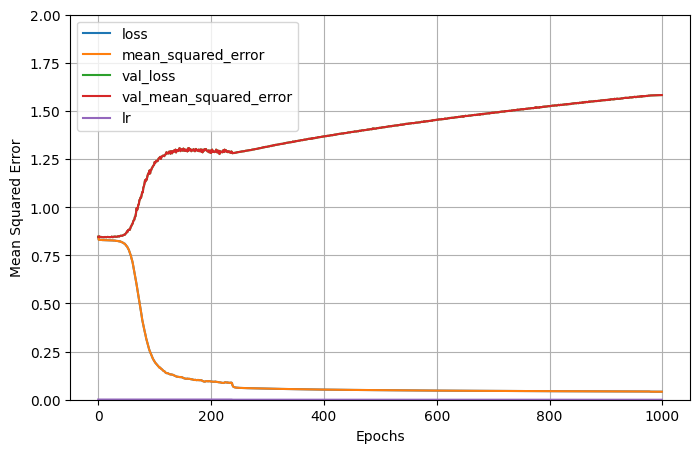

In [16]:
plot_model_history(history)

In [18]:
n = 52
plot_fully_connected_amp_phase_prediction(
    model,
    val_flattened_fluxes_array[n],
    val_amp_phase_array[n][0],
    val_amp_phase_array[n][1]
    )

1/1 [==============================] - 0s 18ms/step
